In [1]:
import sys

sys.path.insert(1, 'C:/Users/peter/Desktop/volatility-forecasting/midas')

from volatility import Panel_GARCH
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from monthdelta import monthdelta
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
ret_matrix = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/ret_matrix.csv')
ret_matrix.set_index(pd.to_datetime(ret_matrix.Date), inplace = True)
ret_matrix = ret_matrix.iloc[:, 1:] * 100

ret_mat = ret_matrix.iloc[1:, :]
nan_cols = np.where(ret_mat.isna().sum().values == 1)[0]
nan_index = np.where(ret_mat.iloc[:, nan_cols].isna() == True)[0]

if len(set(nan_index)) == 1.0:
    ret_mat = ret_mat.drop([ret_mat.index[nan_index[0]]])

In [7]:
y = ret_mat[(ret_mat.index >= datetime(1999,12,1) + monthdelta(17)) & (ret_mat.index < datetime(2005, 1, 1) + monthdelta(17))]
for j in range(len(y.columns)):
    y = y.replace(y.iloc[np.where(y.iloc[:, j].values >= 20)[0], j].values, 20.0) # A 20-nál nagyobb értékeket 20ra állítom
    y = y.replace(y.iloc[np.where(y.iloc[:, j].values <= -20)[0], j].values, -20.0) # A -20-nál kisebb értékeket -20ra állítom
y

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2001-05-01,0.485882,NaN,NaN,1.711380,NaN,-1.756135,2.824317,-1.258407,NaN,-1.955775,...,1.110309,0.225443,1.670422,9.087565,NaN,-0.156321,NaN,2.217483,0.281035,NaN
2001-05-02,1.317817,NaN,NaN,2.513304,NaN,-1.538334,0.252841,-0.943269,NaN,-2.808643,...,0.560910,-2.624240,0.375862,-3.599335,NaN,-5.748685,NaN,-0.022610,1.541198,NaN
2001-05-03,-3.249617,NaN,NaN,-6.326019,NaN,-0.095725,-2.195638,0.965132,NaN,-5.273207,...,-5.230778,-0.463492,1.538478,3.801126,NaN,-2.905726,NaN,-4.273659,-0.572831,NaN
2001-05-04,-0.208276,NaN,NaN,3.115976,NaN,1.841136,1.740055,1.688312,NaN,1.780737,...,-1.783982,1.670083,2.672635,-0.809716,NaN,2.216965,NaN,2.101897,1.453446,NaN
2001-05-07,0.959692,NaN,NaN,-3.115976,NaN,-1.936925,-2.361501,0.876163,NaN,-0.436142,...,-1.522614,0.728348,0.716729,0.809716,NaN,-0.693538,NaN,2.420210,-0.622969,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-05-24,-1.078544,-3.078543,0.314872,0.300400,NaN,-0.205937,3.431710,0.977488,1.775092,0.857785,...,2.071426,-0.481391,1.985555,-0.372375,NaN,-2.156936,0.460974,-1.274616,0.407766,NaN
2006-05-25,-0.617402,0.182392,-0.393746,1.550892,NaN,2.354121,6.076634,0.826970,0.608564,-0.445134,...,-0.838756,2.335319,-0.668644,-0.298934,NaN,1.733100,0.426171,1.133792,0.061697,NaN
2006-05-26,2.101044,5.473829,-0.026351,-1.219880,NaN,-1.011812,0.602872,0.399177,-0.250131,-0.550586,...,0.686775,0.097477,0.284757,3.167830,NaN,-0.794637,-0.524765,1.538275,0.160100,NaN


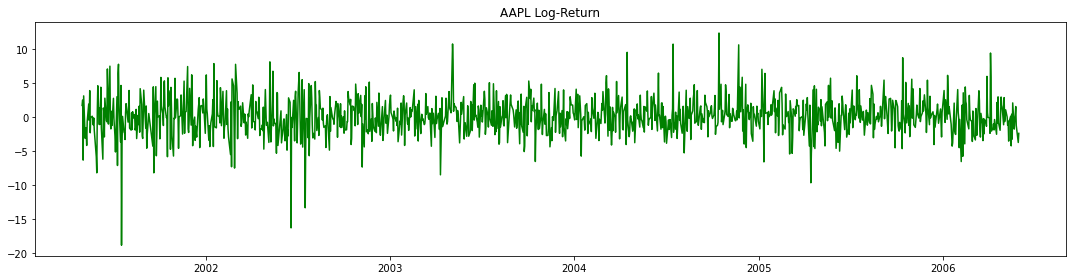

In [22]:
plt.figure(figsize = (15, 4))
plt.plot(pd.to_datetime(y.index), y.AAPL, 'g')
plt.title('AAPL Log-Return')
plt.tight_layout()
plt.show()

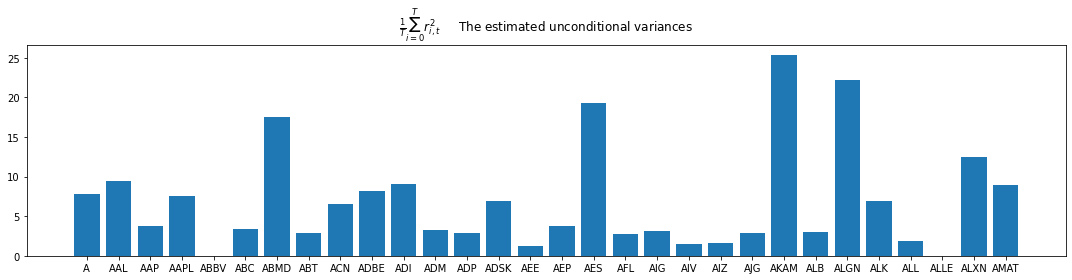

In [21]:
#Ezzel a kezdőértékkel indul meg a sigma2 számolása
plt.figure(figsize= (15,4))
plt.bar(y.columns[:30], np.nanmean(y ** 2, axis = 0)[:30])
plt.title(r'$\frac{1}{T} \sum_{i=0}^T r_{i,t}^2$' + '\t The estimated unconditional variances')
plt.tight_layout()
plt.show()

In [23]:
model = Panel_GARCH()

In [24]:
model.fit(['01', '01'], y)

Loglikelihood:  907.4746840579364 

   Parameters  Standard Error  95% CI Lower  95% CI Higher
0    0.000007         0.00313     -0.006129       0.006143
1    1.000000         0.00512      0.989966       1.010034
